In [1]:
import os
os.chdir("../../")
print(os.getcwd())

d:\PhD_Projects\Mori-Zwanzig-Autoencoder


In [2]:
import torch, pickle, os
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd
from Data.KS.KS_order import KS
# from src.Layers.Autoencoder import Autoencoder_seq

In [3]:
torch.cuda.empty_cache()
exp_dir   = "F:/PhD_Projects/MZA_Cluster_Models/Exp6.3.1_KS_phtest"
# pickle.load(open("Trained_Models/Cluster_Models/Exp4.2.4_Transient_2DCyl_MULTISTEP_numobstest_with_seqmodel_switch/sl33_nhu40_numobs3_bs16_lr5e-5_ph10/args"))
models = []


exp_name_list = [
                 "sl33_nhu40_numobs16_bs256_lr5e-5_ph10_bs256",\
                 "sl33_nhu40_numobs16_bs256_lr5e-5_ph20_bs256",\
                 "sl33_nhu40_numobs16_bs256_lr5e-5_ph30_bs256",\
                 "sl33_nhu40_numobs16_bs256_lr5e-5_ph60_bs256",\
                 "sl33_nhu40_numobs16_bs256_lr5e-5_ph100_bs256"
                 ]
for exp_name in exp_name_list:#os.listdir(exp_dir):
    if exp_name != "results" and exp_name != ".DS_Store":
        print(exp_name)
        models.append(Eval_MZA(exp_dir, exp_name, ae = "Autoencoder_sequential"))
models
# eval_mza = Eval_MZA(exp_dir, exp_name)

sl33_nhu40_numobs16_bs256_lr5e-5_ph10_bs256
########## Imp Info ##########
System:  KS
Using Non-Linear Autoencoder
sl33_nhu40_numobs16_bs256_lr5e-5_ph20_bs256
########## Imp Info ##########
System:  KS
Using Non-Linear Autoencoder
sl33_nhu40_numobs16_bs256_lr5e-5_ph30_bs256
########## Imp Info ##########
System:  KS
Using Non-Linear Autoencoder
sl33_nhu40_numobs16_bs256_lr5e-5_ph60_bs256
########## Imp Info ##########
System:  KS
Using Non-Linear Autoencoder
sl33_nhu40_numobs16_bs256_lr5e-5_ph100_bs256
########## Imp Info ##########
System:  KS
Using Non-Linear Autoencoder


In [4]:
models[0].deactivate_seqmodel

False

Epoch with Minimum train_error:  14673


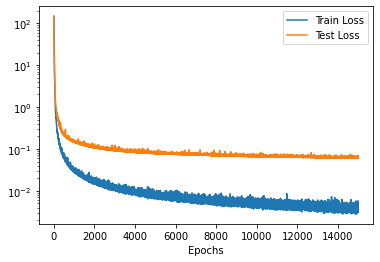

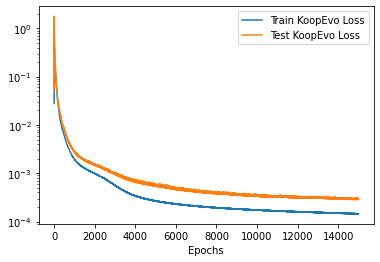

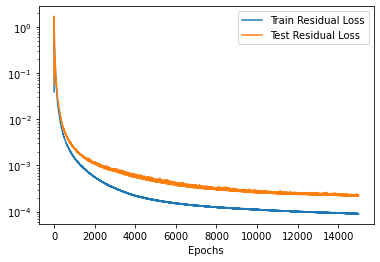

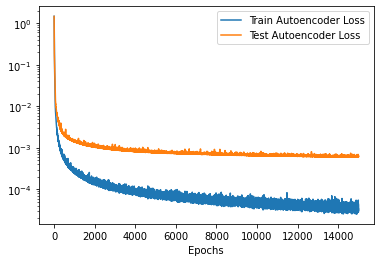

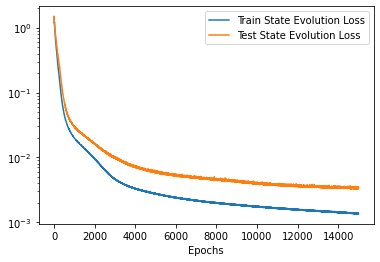

In [5]:
#plot learning curves
models[0].plot_learning_curves()

In [6]:
#for autoencoder_seq loading the strcuture separately for clarity and security
# for i in range(0,len(models)):
    # models[i].autoencoder_model = "Autoencoder_sequential"
    # models[i].model.autoencoder = Autoencoder_seq(input_size = models[i].statedim, latent_size = models[i].num_obs, linear_ae = models[i].linear_autoencoder).to(models[0].device)

for i in range(0,len(models)):
    epoch_num = 7999
    models[i].load_weights(epoch_num, True)

AE_Model: Autoencoder
Koop_Model: Koopman
RNN_Model: LSTM_Model
AE_Model: Autoencoder
Koop_Model: Koopman
RNN_Model: LSTM_Model
AE_Model: Autoencoder
Koop_Model: Koopman
RNN_Model: LSTM_Model
AE_Model: Autoencoder
Koop_Model: Koopman
RNN_Model: LSTM_Model
AE_Model: Autoencoder
Koop_Model: Koopman
RNN_Model: LSTM_Model


In [7]:
# for i in range(0,len(models)):

ph0 = models[0].pred_horizon 
models[0].pred_horizon = 1

In [8]:
#One Step Prediction

model_num = 0
# models[model_num].data_dir = models[-2].data_dir
models[model_num].load_and_preproc_data()
models[model_num].create_dataset(mode = "Test")
dataset = models[model_num].test_dataset
num_trajs = models[model_num].test_num_trajs

# eval_mza.train_size = 0.9
for i in range(1):#len(models)):
    i=model_num
    # del eval_mza.lp_data 
    # torch.cuda.empty_cache()
    # del eval_mza.train_dataset
    # del eval_mza.train_dataloader
    if not models[i].deactivate_seqmodel:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE, koop_out, seqmodel_out = models[i].predict_onestep(dataset, num_trajs)
    else:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE = models[i].predict_onestep(dataset, num_trajs)
    print(x_nn_hat.shape, Phi_nn_hat.shape, Phi_nn.shape)

    #Plotting one step prediction
    x_nn_hat.shape

models[0].pred_horizon = ph0




Data Shape:  (1, 27000, 128)
Not normalizing Input
Test_Shape:  (1, 5400, 128)
Time:  0.24306726455688477


AttributeError: 'Autoencoder' object has no attribute 'e_fc1'

In [9]:
Phi = models[0].test_data

Text(0, 0.5, 'MSE')

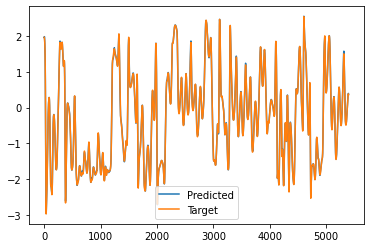

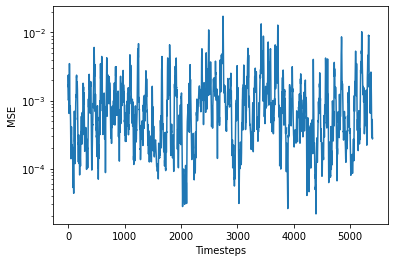

In [10]:
for i in range (1):
    plt.figure()
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,0], label = "Predicted")
    plt.plot(Phi_nn.cpu().numpy()[i,:,0], label = "Target")
    plt.legend()

plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")

In [10]:
#multistep prediction
timesteps = 1000
initial_step = 0
initial_conditions = Phi_nn[:,initial_step,:].to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat = torch.zeros((len(models),1,timesteps+1,models[0].statedim)).to(models[0].device)
Phi_ms_koop = torch.zeros((len(models),1,timesteps,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

for i in range(len(models)):
    x_hat_temp, Phi_ms_hat[i], Phi_ms_koop[i], xkoop_hat_temp, xseq_hat_temp = models[i].predict_multistep(initial_conditions, timesteps)
    x_ms_hat.append(x_hat_temp)
    xkoop_ms_hat.append(xkoop_hat_temp)
    xseq_ms_hat.append(xseq_hat_temp)
print(Phi_ms_hat.shape, Phi_ms_koop.shape)


ic shape: torch.Size([1, 128])
torch.Size([5, 1, 1001, 128]) torch.Size([5, 1, 1000, 128])


Text(0, 0.5, 'kinetic energy')

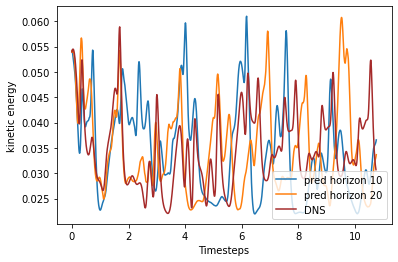

In [12]:
#kinetic energy of multistep rpediciton
def KS_kinetic_energy(Phi):
    L = 22
    k = 0.5*np.mean(Phi**2, axis = -1)/L
    return k

plt.figure()

lt = 93.024
x = np.arange(timesteps+1)/lt

for i in [0,1]:
    
    # plt.plot(x, KS_kinetic_energy(Phi_ms_hat[i,0,:].detach().cpu().numpy()), label = f"ph {models[i].pred_horizon}")
    plt.plot(x, KS_kinetic_energy(Phi_ms_hat[i,0,:].detach().cpu().numpy()), label = f"pred horizon {models[i].pred_horizon}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(x[:-1], KS_kinetic_energy(Phi[0,initial_step:timesteps+initial_step]), label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("kinetic energy")

Text(0, 0.5, 'Probability Density')

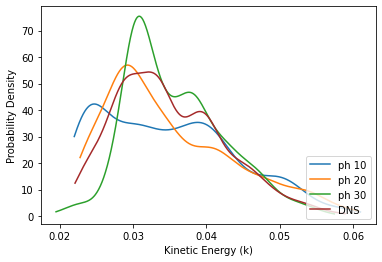

In [13]:
#pdf of kinteic energy

plt.figure()

for i in [0,1,2]:
    k, pdf = Eval_MZA.calc_pdf(KS_kinetic_energy(Phi_ms_hat[i,0,:].detach().cpu().numpy()))
    plt.plot(k,pdf , label = f"ph {models[i].pred_horizon}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
k, pdf = Eval_MZA.calc_pdf(KS_kinetic_energy(Phi[0,initial_step:timesteps+initial_step]))
plt.plot(k, pdf, label = "DNS",color = "brown")

plt.legend(loc='lower right')

plt.xlabel('Kinetic Energy (k)')
plt.ylabel('Probability Density')

[  0.           0.29156312   0.58312625   0.87468937   1.16625249
   1.45781562   1.74937874   2.04094186   2.33250499   2.62406811
   2.91563123   3.20719436   3.49875748   3.7903206    4.08188373
   4.37344685   4.66500997   4.9565731    5.24813622   5.53969934
   5.83126247   6.12282559   6.41438871   6.70595184   6.99751496
   7.28907808   7.58064121   7.87220433   8.16376745   8.45533058
   8.7468937    9.03845682   9.33001995   9.62158307   9.91314619
  10.20470932  10.49627244  10.78783556  11.07939869  11.37096181
  11.66252493  11.95408806  12.24565118  12.5372143   12.82877743
  13.12034055  13.41190367  13.7034668   13.99502992  14.28659304
  14.57815617  14.86971929  15.16128241  15.45284554  15.74440866
  16.03597178  16.3275349   16.61909803  16.91066115  17.20222427
  17.4937874   17.78535052  18.07691364  18.36847677 -18.66003989]
(65,)
(1000, 65)


Text(0, 0.5, 'kinetic energy')

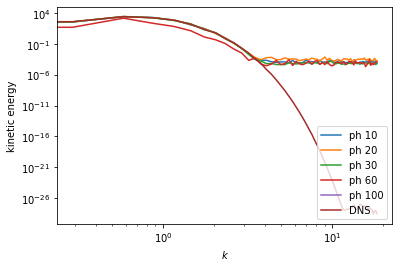

In [14]:
#energy spectrum
dt = 0.025
N  = 128
num_trajs = 1
max_n = int(8000/dt)
L = 21.55/(2*np.pi)#1/np.sqrt(0.085)
kse = KS(dt=dt, N=N, lambda2=1, L = L)

plt.figure()

timesteps_ke = 1000
lt = 93.024
x = np.arange(1000)/lt

Phi_ms_hat_fft = np.fft.rfft(Phi_ms_hat.detach().cpu().numpy())
k_fft = 0.5*np.mean(np.abs(Phi_ms_hat_fft)**2, axis = -2)
print(k_fft[0,0].shape)
for i in [0,1,2,3,4]:
    
    plt.loglog(kse.k[:-1], k_fft[i,0,:-1], label = f"ph {models[i].pred_horizon}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
Phi_fft = np.fft.rfft(Phi[0,initial_step:timesteps+initial_step], axis = -1)
print(Phi_fft.shape)
k_fft = 0.5*np.mean(np.abs(Phi_fft)**2, axis = 0)
plt.loglog(kse.k[:-1], k_fft[:-1], label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel(r"$k$")
plt.ylabel(r"kinetic energy")

Text(0, 0.5, '$\\mathcal{K}(x_{2})$')

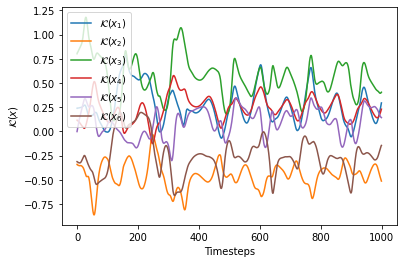

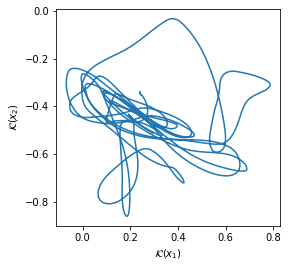

In [15]:
#plotting koopman mode evolution
plt.figure()
model_num = 1
for n in [0,1,2,3,4,5]:#range(models[model_num].num_obs):
    plt.plot(xkoop_ms_hat[model_num][0,:,n].cpu().numpy(), label = r"$\mathcal{K}$"+f"$(x_{n+1})$")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel(r"$\mathcal{K}(x)$")


plt.figure()
plt.gca().set_aspect('equal')
plt.plot(xkoop_ms_hat[model_num][0,:,0].cpu().numpy(), xkoop_ms_hat[model_num][0,:,1].cpu().numpy())

plt.xlabel(r"$\mathcal{K}(x_{1})$")
plt.ylabel(r"$\mathcal{K}(x_{2})$")

Text(0, 0.5, 'Observables $  L_{2} Norm$')

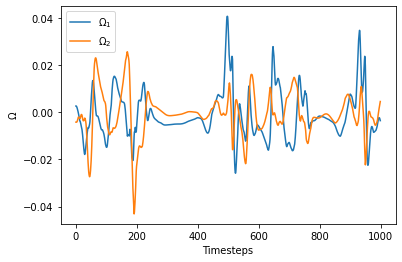

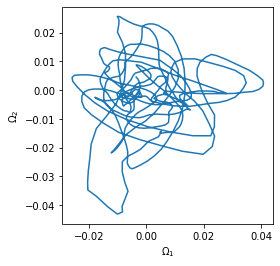

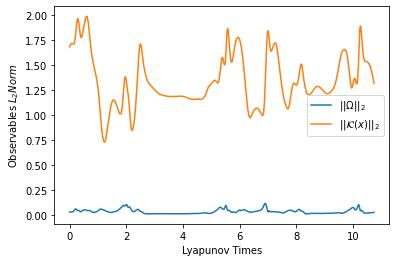

In [18]:
#plotting seqmodel mode evolution
plt.figure()
model_num = 1
tgt_xseq_ms_hat = xseq_ms_hat[model_num].cpu().numpy()
tgt_xkoop_ms_hat = xkoop_ms_hat[model_num].cpu().numpy()
for n in [0,1]:#range(models[model_num].num_obs):
    plt.plot(xseq_ms_hat[model_num][0,:,n].cpu().numpy(), label = r"$\Omega$"+f"$_{n+1}$")

plt.legend()
plt.xlabel("Timesteps")
plt.ylabel(r"$\Omega$")

plt.figure()
plt.gca().set_aspect('equal')
plt.plot(xseq_ms_hat[model_num][0,:,0].cpu().numpy(), xseq_ms_hat[model_num][0,:,1].cpu().numpy())
plt.xlabel(f"$\Omega_{1}$")
plt.ylabel(f"$\Omega_{2}$")

plt.figure()
tgt_xseq_norm = np.linalg.norm(tgt_xseq_ms_hat, axis = -1)
tgt_xkoop_norm = np.linalg.norm(tgt_xkoop_ms_hat, axis = -1)

lt = 93.024
x = np.arange(timesteps)/lt

# plt.plot((tgt_xseq_norm/np.max(tgt_xseq_norm, axis = -1))[0,:], label = r"$||\Omega||_{2}$")
# plt.plot((tgt_xkoop_norm/np.max(tgt_xkoop_norm, axis = -1))[0,:], label = r"$||\mathcal{K}(x)||_{2}$")

plt.plot(x, (tgt_xseq_norm)[0,:], label = r"$||\Omega||_{2}$")
plt.plot(x, (tgt_xkoop_norm)[0,:], label = r"$||\mathcal{K}(x)||_{2}$")

plt.legend()
plt.xlabel("Lyapunov Times")
plt.ylabel("Observables " + r"$  L_{2} Norm$")

torch.Size([1, 5399, 128]) torch.Size([5, 1, 1001, 128])


Text(0, 0.5, 'MSE')

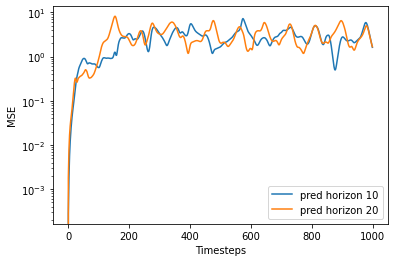

In [17]:
print(Phi_nn.shape, Phi_ms_hat.shape)
State_MSE_multistep = torch.zeros((len(models),timesteps))

plt.figure()
for i in [0,1]:#range(len(models)-3):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[i,:,:timesteps]).detach().cpu()
    # if i!=len(models)-1:
    plt.semilogy(State_MSE_multistep[i].numpy(), label = f"pred horizon {models[i].pred_horizon}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")

# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("MSE")
# np.save("koopman_numobs32.npy",Phi_hat.cpu().numpy())

In [ ]:
#calculating kinetic energy for multistep prediction
k_ms_pred = energy(U_ms_hat, V_ms_hat)
print(k_ms_pred.shape)
plt.figure()
for i in [0,1,2,3,4,5,6,7]:
    
    plt.plot(k_ms_pred[i,0,:], label = f"Number of Hidden Units {models[i].num_hidden_units}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(k[0,initial_step:], label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("kinetic energy")

Jacobian Analysis

In [19]:
#multistep prediction
timesteps_jac = 100
initial_step = 0
initial_conditions = Phi_nn[:,initial_step,:].to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat = torch.zeros((len(models),1,timesteps_jac+1,models[0].statedim)).to(models[0].device)
Phi_ms_koop = torch.zeros((len(models),1,timesteps_jac,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

grad_xn_xseq = []

for i in [0,1,2,3,4,5]:#range(len(models)):
    
    grad_xn_xseq.append(models[i].jacobian_calc(initial_conditions, timesteps_jac))
    n = torch.mean(torch.norm(grad_xn_xseq[i].cpu(), dim = -1),dim = 1)
    print(i, n.shape)

print(grad_xn_xseq[0].shape)

ic shape: torch.Size([1, 128])


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


0 torch.Size([1, 32])
1 torch.Size([1, 32])
2 torch.Size([1, 32])
3 torch.Size([1, 32])
4 torch.Size([1, 32])


IndexError: list index out of range

torch.Size([40])
0 tensor([[0.0004, 0.0007, 0.0009, 0.0012, 0.0014, 0.0015, 0.0016, 0.0017, 0.0020,
         0.0026, 0.0033, 0.0041, 0.0050, 0.0059, 0.0069, 0.0082, 0.0098, 0.0122,
         0.0155, 0.0197, 0.0249, 0.0308, 0.0373, 0.0448, 0.0554, 0.0738, 0.1051,
         0.1525, 0.2155, 0.2904, 0.3703, 0.4460]])
1 tensor([[0.0011, 0.0014, 0.0018, 0.0022, 0.0026, 0.0030, 0.0034, 0.0039, 0.0045,
         0.0051, 0.0058, 0.0065, 0.0074, 0.0085, 0.0097, 0.0111, 0.0128, 0.0147,
         0.0170, 0.0195, 0.0222, 0.0251, 0.0281, 0.0316, 0.0359, 0.0416, 0.0487,
         0.0567, 0.0652, 0.0756, 0.0936, 0.1326]])


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5800\2371156166.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([-tick for tick in plt.gca().get_xticks()])


Text(0.5, 0, 'Timesteps')

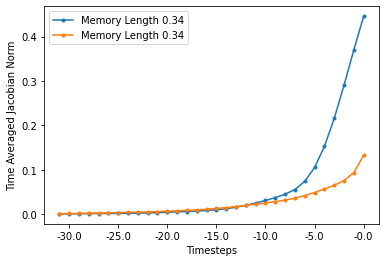

In [22]:
x = torch.arange(timesteps_jac)/lt
print(x[:40].shape)
plt.figure()
for i in [0,1]:#range(len(models)):
    
    n = torch.mean(torch.norm(grad_xn_xseq[i].cpu(), dim = -1),dim = 1)
    print(i, n)
    inv_n = torch.flip(n,[1])
    inv_x = torch.flip(x,[0])
    plt.plot( inv_n[0,:40], ".-", label = f"Memory Length {round((models[i].seq_len -1)/lt,2)}")
plt.legend()
plt.gca().invert_xaxis()
plt.gca().set_xticklabels([-tick for tick in plt.gca().get_xticks()])
plt.ylabel("Time Averaged Jacobian Norm")
plt.xlabel("Timesteps")

Koopman Analysis

[ 0.99957824+0.00048093j  0.99957824-0.00048093j  0.99770755+0.j
  0.99236923+0.00749993j  0.99236923-0.00749993j  0.9812918 +0.j
  0.9570698 +0.02274488j  0.9570698 -0.02274488j  0.87013894+0.j
  0.2635828 +0.36868107j  0.2635828 -0.36868107j  0.10611814+0.j
 -0.07472365+0.j         -0.4300854 +0.22445184j -0.4300854 -0.22445184j
 -0.57397604+0.j        ]


Text(0, 0.5, '$Img(\\lambda)$')

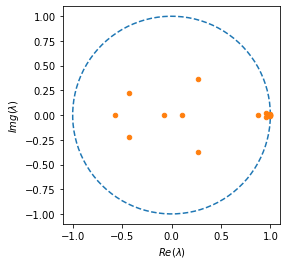

In [ ]:
#eigenvalue study
plt.figure()
plt.gca().set_aspect('equal')

angles = np.linspace(0, 2 * np.pi, 100)
unit_circle = np.exp(1j * angles)
plt.plot(unit_circle.real, unit_circle.imag, '--', label = "Unit Circle")

for i in [1]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    print(w)
    # plt.matshow(mat)
    # plt.colorbar()
    # plt.figure()
    plt.plot(np.real(w), np.imag(w), ".", markersize = 9, label = f"Num Observables {models[i].num_obs}")

plt.xlabel(r"$Re(\lambda)$")
plt.ylabel(r"$Img(\lambda)$")
# plt.legend()

array([-1.6869426e-03+1.9245436e-03j, -1.6869426e-03-1.9245436e-03j,
       -9.1803446e-03+0.0000000e+00j, -3.0525882e-02+3.0229835e-02j,
       -3.0525882e-02-3.0229835e-02j, -7.5541764e-02+0.0000000e+00j,
       -1.7438652e-01+9.5042616e-02j, -1.7438652e-01-9.5042616e-02j,
       -5.5640948e-01+0.0000000e+00j, -3.1655762e+00+3.8004696e+00j,
       -3.1655762e+00-3.8004696e+00j, -8.9728088e+00+0.0000000e+00j,
       -1.0375834e+01+1.2566371e+01j, -2.8933454e+00+1.0642386e+01j,
       -2.8933454e+00-1.0642386e+01j, -2.2206705e+00+1.2566371e+01j],
      dtype=complex64)

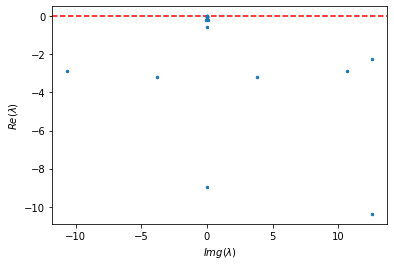

In [ ]:
plt.figure()

plt.axhline(0, color='red', linestyle='--')

# plt.text(0.17, 0.075, 'x = 0.17', color='green')
for i in [1]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    lamb = (np.log(w)/0.25)
    plt.plot(np.imag(lamb[:]),np.real(lamb[:]),".", markersize = 5, label = f"Num Observables {models[i].num_obs}")

plt.ylabel(r"$Re(\lambda)$")
plt.xlabel(r"$Img(\lambda)$")

# plt.ylim(-0.1,0.1)
# plt.xlim(-1,1)
# plt.legend()
lamb

<Figure size 432x288 with 0 Axes>

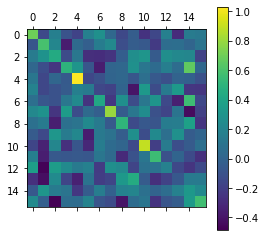

In [ ]:
#Matrix
plt.figure()


for i in []:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    plt.matshow(mat)
    plt.colorbar()
    # plt.figure()
    # plt.plot(np.real(w), np.imag(w), ".", label = f"Num Observables {models[i].num_obs}")

# plt.legend()

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")

if device.type == 'cuda':

    print(torch.cuda.get_device_name(0))

    print('Memory Usage:')

    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')

    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.1 GB
Cached:    3.9 GB


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\cuda\memory.py:391: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(
